In [97]:
# LIVE game analytics

gameID = 3394
#gameID = 3403

team1name = 'TPS'
team2name = 'Happee'

#team1name = 'Indians'
#team2name = 'EräViikingit'

import csv
import requests
import json
import math

from statistics import mean
from scipy.stats import binom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

#from ipynb.fs.full.SingleGameRoster import getSingleGameRoster

teams = pd.read_json('teams_22_23.json')
teams = teams.drop_duplicates('HomeTeam', keep='last')
teams = teams.drop(['AwayTeam','AwayTeamID','GameRules'], axis=1)
teams = teams.rename(columns={"HomeTeam": "TeamName", "HomeTeamID": "TeamID"})

team1nr = teams[teams['TeamName'] == team1name].iloc[0,1]
team1nr = str(team1nr)
team2nr = teams[teams['TeamName'] == team2name].iloc[0,1]
team2nr = str(team2nr)

maxX = 1024
maxY = 514

xG_matrix = [
    
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 16.67, 0.0, 16.67, 40.0, 0.0, 22.22, 54.55, 0.0, 25.0, 0.0, 0.0],
    [0.0, 21.43, 16.67, 0.0, 11.88, 41.79, 60.71, 31.39, 10.25, 10.39, 0.0, 7.89, 0.0],
    [0.0, 4.0, 13.24, 13.9, 19.26, 38.28, 42.19, 31.88, 15.53, 12.96, 8.57, 4.29, 0.0],
    [0.0, 7.14, 12.7, 14.29, 17.87, 26.11, 28.17, 23.4, 13.77, 11.86, 8.72, 6.75, 0.0],
    [3.45, 7.51, 9.2, 11.76, 16.45, 21.8, 24.47, 19.66, 14.41, 9.27, 6.43, 5.71, 5.56],
    [12.86, 6.29, 8.86, 11.95, 15.53, 18.56, 20.68, 15.78, 11.88, 9.12, 6.01, 6.65, 0.0],
    [6.03, 6.9, 7.48, 9.75, 13.65, 16.0, 15.29, 13.7, 8.85, 6.38, 6.25, 7.56, 4.55],
    [7.02, 6.16, 6.15, 9.64, 8.85, 12.64, 12.73, 10.48, 8.68, 5.59, 5.29, 5.33, 5.41],
    [8.16, 4.88, 5.34, 5.56, 7.28, 9.76, 9.65, 9.82, 6.25, 6.18, 3.52, 6.16, 12.5],
    [7.69, 4.91, 4.57, 5.44, 5.7, 7.35, 7.15, 6.38, 5.29, 4.39, 2.5, 5.76, 8.33],
    [1.89, 2.41, 3.3, 3.55, 4.77, 5.24, 5.28, 5.98, 5.32, 4.31, 3.84, 5.93, 8.33],
    [2.86, 3.33, 1.29, 3.27, 3.31, 5.03, 5.74, 4.76, 3.2, 2.83, 4.64, 4.55, 0.0],
    [5.56, 6.98, 6.72, 6.32, 5.88, 6.38, 8.9, 4.03, 1.67, 3.05, 4.39, 8.22, 9.09],

    ];

xGOT_matrix = [
    
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 25.0, 0.0, 16.67, 66.67, 0.0, 28.57, 60.0, 0.0, 25.0, 0.0, 0.0], 
    [0.0, 23.08, 16.67, 0.0, 18.46, 46.06, 62.96, 38.45, 14.62, 16.0, 0.0, 9.38, 0.0], 
    [0.0, 5.56, 18.75, 20.97, 27.52, 43.92, 46.41, 37.84, 22.97, 21.78, 16.54, 6.67, 0.0], 
    [0.0, 13.79, 23.13, 23.19, 26.32, 31.98, 33.8, 30.16, 21.49, 21.49, 18.52, 15.49, 0.0], 
    [9.09, 15.83, 18.09, 20.53, 25.98, 30.73, 33.88, 29.69, 24.7, 18.95, 13.52, 12.93, 14.29], 
    [30.0, 12.91, 18.07, 22.28, 27.26, 30.6, 32.72, 28.78, 24.11, 20.1, 14.47, 16.13, 0.0], 
    [12.28, 16.48, 17.2, 20.85, 27.9, 31.02, 29.25, 29.08, 21.58, 16.47, 16.17, 18.05, 9.09], 
    [18.75, 16.4, 16.47, 24.29, 22.33, 30.22, 28.02, 27.85, 24.12, 16.49, 15.16, 14.07, 13.33], 
    [17.14, 13.18, 15.24, 16.27, 21.33, 25.98, 25.43, 27.54, 20.81, 18.95, 10.76, 14.97, 23.53], 
    [21.21, 14.01, 14.16, 17.5, 18.62, 22.34, 22.07, 20.78, 18.26, 14.04, 7.86, 18.67, 13.33], 
    [4.76, 7.32, 10.56, 12.7, 15.67, 17.67, 17.12, 20.0, 16.59, 13.64, 12.59, 17.02, 33.33], 
    [8.33, 7.81, 3.88, 10.45, 10.26, 14.56, 16.72, 14.69, 9.32, 11.11, 12.5, 10.0, 0.0], 
    [9.09, 13.43, 11.11, 14.46, 14.29, 15.25, 18.69, 11.0, 4.76, 6.58, 8.33, 13.33, 14.29]

    ];

xG_matrix_women = [
    
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
        [0.0, 27.27, 28.57, 16.67, 3.45, 44.44, 70.0, 32.0, 10.14, 12.9, 0.0, 20.0, 0.0], 
        [0.0, 16.67, 2.63, 12.33, 15.92, 35.45, 39.57, 27.67, 15.36, 12.35, 3.33, 0.0, 0.0], 
        [0.0, 2.56, 9.73, 10.47, 19.92, 23.48, 27.51, 22.81, 16.55, 8.23, 6.96, 2.38, 0.0], 
        [8.33, 3.54, 3.06, 11.49, 15.24, 21.83, 23.11, 19.9, 12.11, 9.41, 4.64, 3.96, 0.0], 
        [4.55, 3.8, 5.6, 7.53, 11.67, 15.05, 18.72, 14.91, 9.78, 5.74, 4.42, 3.16, 0.0], 
        [5.26, 3.49, 5.98, 7.59, 11.24, 11.84, 11.48, 9.32, 8.58, 4.59, 2.45, 7.05, 0.0], 
        [7.32, 4.03, 3.88, 6.55, 5.81, 9.9, 10.94, 6.25, 5.19, 4.66, 4.83, 3.21, 50.0], 
        [4.88, 0.97, 2.88, 4.38, 2.75, 5.73, 7.77, 5.91, 3.75, 4.85, 4.45, 1.1, 0.0], 
        [0.0, 2.45, 3.19, 3.96, 4.17, 5.4, 6.28, 2.61, 4.38, 3.87, 3.69, 2.44, 0.0], 
        [0.0, 2.72, 2.84, 2.58, 3.31, 3.74, 3.46, 4.18, 3.88, 3.17, 2.22, 2.0, 0.0], 
        [0.0, 3.3, 3.25, 3.61, 3.98, 3.8, 4.09, 5.18, 5.0, 3.36, 2.44, 7.5, 0.0], 
        [0.0, 1.44, 2.85, 1.15, 2.83, 4.82, 4.02, 5.88, 3.03, 1.59, 1.0, 1.05, 0.0],
        
        ];

xGOT_matrix_women = [

        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
        [0.0, 37.5, 40.0, 20.0, 5.26, 46.81, 70.0, 39.72, 15.56, 19.05, 0.0, 23.08, 0.0], 
        [0.0, 21.05, 25.0, 23.68, 24.38, 40.88, 43.36, 34.71, 23.36, 21.65, 6.25, 0.0, 0.0], 
        [0.0, 4.76, 17.74, 17.82, 31.13, 30.41, 34.9, 30.46, 25.79, 16.16, 15.09, 5.56, 0.0], 
        [11.11, 6.9, 6.42, 23.53, 25.72, 34.44, 34.71, 32.47, 23.82, 19.47, 11.04, 8.0, 0.0], 
        [11.11, 9.09, 12.88, 16.48, 22.58, 27.36, 32.37, 28.71, 20.99, 14.55, 11.98, 6.94, 0.0], 
        [12.5, 8.16, 16.08, 19.55, 26.82, 23.82, 25.46, 24.88, 22.45, 12.79, 6.94, 14.47, 0.0], 
        [16.67, 10.85, 10.62, 17.21, 17.62, 23.51, 26.94, 19.15, 14.5, 13.86, 15.13, 6.85, 50.0], 
        [15.38, 2.73, 9.44, 15.57, 8.9, 17.28, 23.84, 18.12, 13.28, 15.79, 13.27, 2.94, 0.0], 
        [0.0, 7.32, 9.87, 14.91, 13.82, 17.42, 21.49, 10.23, 15.84, 15.48, 9.78, 8.0, 0.0], 
        [0.0, 7.58, 9.0, 8.14, 12.35, 13.64, 10.34, 16.22, 13.51, 9.38, 6.82, 5.56, 0.0], 
        [33.33, 9.68, 17.54, 10.94, 13.56, 13.64, 14.67, 16.13, 17.39, 9.52, 7.69, 18.75, 0.0], 
        [0.0, 7.69, 1.62, 2.38, 7.14, 12.12, 12.33, 14.29, 7.69, 3.85, 0.0, 4.44, 0.0], 
    
        ];

def calcxG(x,y):

    if x > maxX / 2: # välille 0 - 13
        xd = math.floor((maxX - x)/ maxX*2 * 14)
        yd = math.floor(y / maxY * 13)
    else:
        xd = math.floor(x / maxX*2 * 14)
        yd = math.floor(y / maxY * 13)
    
    xGOT = xGOT_matrix[xd][yd] / 100
    xG = xG_matrix[xd][yd] / 100
    return (xGOT, xG)

data = 'GameID='+str(gameID)+'/helper/getshootings.php'

headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8,fi;q=0.7',
    'Connection': 'keep-alive',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'Origin': 'https://www.tilastopalvelu.fi',
    'Referer': 'https://www.tilastopalvelu.fi/fb/gameshootingmap/?gid='+str(gameID)+'/helper/getshootings.php',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36',
    'X-Requested-With': 'XMLHttpRequest',
    'sec-ch-ua': '"Chromium";v="104", " Not A;Brand";v="99", "Google Chrome";v="104"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
}

response = requests.post('https://www.tilastopalvelu.fi/fb/gameshootingmap/helper/getshootings.php', headers=headers, data=data)
temp = response.json()
shots = pd.DataFrame(temp)
shots['xGOT'] = 0
shots['xG'] = 0

for i in range(len(shots)):
    x = float(shots.loc[i]['ShotX'])
    if x == 512:
        x = 513
    y = float(shots.loc[i]['ShotY'])
    (xGOT, xG) = calcxG(x,y)
    if shots.loc[i]['EventType'] == '1' or shots.loc[i]['EventType'] == '2':
        shots.loc[i,'xGOT'] = xGOT
    else: shots.loc[i,'xGOT'] = 0
    shots.loc[i,'xG'] = xG
    

# Get Players

rosters = pd.DataFrame()
    
cookies = {
    'c4912372421e1e6f206a78cd84a3c469': 'n8rth31cu4pn0pjlgjih2aihr1',
    '_ga': 'GA1.2.907313442.1673438953',
    '_gid': 'GA1.2.701197222.1673887324',
    '_gat': '1',
}

headers = {
    'Accept': '*/*',
    'Accept-Language': 'fi-FI,fi;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
    # 'Content-Length': '0',
    # 'Cookie': 'c4912372421e1e6f206a78cd84a3c469=n8rth31cu4pn0pjlgjih2aihr1; _ga=GA1.2.907313442.1673438953; _gid=GA1.2.701197222.1673887324; _gat=1',
    'Origin': 'http://tilastopalvelu.fi',
    'Referer': 'http://tilastopalvelu.fi/fb/index.php?option=com_content&view=article&id=7&gid='+str(gameID)+'&lang=',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
}

params = {
    'team': 'home',
    'game': str(gameID),
}

response = requests.post(
    'http://tilastopalvelu.fi/fb/modules/mod_gamerosters/helper/gamerosters.php',
    params=params,
    cookies=cookies,
    headers=headers,
    verify=False,
)

data = response.json()
homeRoster = pd.json_normalize(data, record_path =['players'])

cookies = {
    'c4912372421e1e6f206a78cd84a3c469': 'n8rth31cu4pn0pjlgjih2aihr1',
    '_ga': 'GA1.2.907313442.1673438953',
    '_gid': 'GA1.2.701197222.1673887324',
    '_gat': '1',
}

headers = {
    'Accept': '*/*',
    'Accept-Language': 'fi-FI,fi;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
    # 'Content-Length': '0',
    # 'Cookie': 'c4912372421e1e6f206a78cd84a3c469=n8rth31cu4pn0pjlgjih2aihr1; _ga=GA1.2.907313442.1673438953; _gid=GA1.2.701197222.1673887324; _gat=1',
    'Origin': 'http://tilastopalvelu.fi',
    'Referer': 'http://tilastopalvelu.fi/fb/index.php?option=com_content&view=article&id=7&gid='+str(gameID)+'&lang=',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
}
params = {
    'team': 'away',
    'game': str(gameID),
}

response = requests.post(
    'http://tilastopalvelu.fi/fb/modules/mod_gamerosters/helper/gamerosters.php',
    params=params,
    cookies=cookies,
    headers=headers,
    verify=False,
)

data = response.json()
awayRoster = pd.json_normalize(data, record_path =['players'])
awayRoster['GameDate'] = homeRoster.iloc[0].GameDate

rosters = pd.concat([rosters, homeRoster, awayRoster])

rosters = rosters.drop(['StatName','PlayerDob','Height','Weight','RPlayer','YPlayer','FPlayer','GameRosterUniqueID'], axis=1)
rosters['PlayerLastName'] = rosters['PlayerLastName'].str.capitalize()
rosters.index = range(len(rosters.index))

players = rosters
players['TeamID'] = ""
players['xG'] = 0
players['xGOT'] = 0
players['xGOT/Team'] = 0
players['Blocked xG'] = 0
players['Shots'] = 0
players['Goals'] = 0
players['Assists'] = 0

for nr in range(len(players)):
    if players['TeamName'].iloc[nr] == team1name:
        players['TeamID'].iloc[nr] = team1nr
    elif players['TeamName'].iloc[nr] == team2name:
        players['TeamID'].iloc[nr] = team2nr

for i in range(len(shots)):
    pl = shots.loc[i]['ShootingPlayerID']
    bl = shots.loc[i]['BlockingPlayerID']
    rw = players.index[players['PlayerUniqueID'] == pl].tolist()
    blrw = players.index[players['PlayerUniqueID'] == bl].tolist()
    if shots.loc[i]['EventType'] == '1' or shots.loc[i]['EventType'] == '2':
        players['xGOT'].iloc[rw[0]] += shots['xGOT'].loc[i]
    else: players['xGOT'].iloc[rw[0]] += 0
    if shots.loc[i]['EventType'] == '3':
        players['Blocked xG'].iloc[blrw[0]] += shots['xG'].loc[i]
    players['xG'].iloc[rw[0]] += shots['xG'].loc[i]
    players['Shots'].iloc[rw[0]] += 1
    if shots.loc[i]['EventType'] == '1':
        players['Goals'].iloc[rw[0]] += 1
        assjersey = shots.loc[i]['Ass1Jersey']
        shooterid = shots.loc[i]['ShootingTeamID']
        ass = players.index[(players['PlayerJerseyNr'] == assjersey) & (players['TeamID'] == shooterid)].tolist()
        if ass != []:
            players['Assists'].iloc[ass[0]] += 1
        
        
team1 = shots[(shots['ShootingTeamID'] == team1nr)]
team2 = shots[(shots['ShootingTeamID'] == team2nr)]

team1xGot = shots[(shots['ShootingTeamID'] == team1nr) & ((shots['EventType'] == '1') | (shots['EventType'] == '2'))]
team2xGot = shots[(shots['ShootingTeamID'] == team2nr) & ((shots['EventType'] == '1') | (shots['EventType'] == '2'))]

team1xGmis = shots[(shots['ShootingTeamID'] == team1nr) & (shots['EventType'] == '0')]
team2xGmis = shots[(shots['ShootingTeamID'] == team2nr) & (shots['EventType'] == '0')]

team1saxG = shots[(shots['ShootingTeamID'] == team1nr) & (shots['EventType'] == '2')]
team2saxG = shots[(shots['ShootingTeamID'] == team2nr) & (shots['EventType'] == '2')]

team1goxG = shots[(shots['ShootingTeamID'] == team1nr) & (shots['EventType'] == '1')]
team2goxG = shots[(shots['ShootingTeamID'] == team2nr) & (shots['EventType'] == '1')]

team1xG = np.round(team1['xG'].sum(),decimals=2)
team2xG = np.round(team2['xG'].sum(),decimals=2)

team1ot = np.round(team1xGot['xGOT'].sum(),decimals=2)
team2ot = np.round(team2xGot['xGOT'].sum(),decimals=2)

team1otshots = len(team1xGot.index)
team2otshots = len(team2xGot.index)

team1mis = np.round(team1xGmis['xG'].sum(),decimals=2)
team2mis = np.round(team2xGmis['xG'].sum(),decimals=2)

team1sav = np.round(team1saxG['xG'].sum(),decimals=2)
team2sav = np.round(team2saxG['xG'].sum(),decimals=2)

team1go = len(team1goxG.index)
team2go = len(team2goxG.index)

team1sh = len(team1)
team2sh = len(team2)
team1list = players[players['TeamName'] == team1name]
team2list = players[players['TeamName'] == team2name]
team1blxG = np.round(team1list['Blocked xG'].sum(),decimals=2)
team2blxG = np.round(team2list['Blocked xG'].sum(),decimals=2)

t1l1 = players[(players['TeamName'] == team1name) & (players['PlayerLine'] == '1')]
t1l1xG = np.round(t1l1['xG'].sum(),decimals=2)
t1l1xGOT = np.round(t1l1['xGOT'].sum(),decimals=2)
t1l1go = t1l1['Goals'].sum()
t1l2 = players[(players['TeamName'] == team1name) & (players['PlayerLine'] == '2')]
t1l2xG = np.round(t1l2['xG'].sum(),decimals=2)
t1l2xGOT = np.round(t1l2['xGOT'].sum(),decimals=2)
t1l2go = t1l2['Goals'].sum()
t1l3 = players[(players['TeamName'] == team1name) & (players['PlayerLine'] == '3')]
t1l3xG = np.round(t1l3['xG'].sum(),decimals=2)
t1l3xGOT = np.round(t1l3['xGOT'].sum(),decimals=2)
t1l3go = t1l3['Goals'].sum()

t2l1 = players[(players['TeamName'] == team2name) & (players['PlayerLine'] == '1')]
t2l1xG = np.round(t2l1['xG'].sum(),decimals=2)
t2l1xGOT = np.round(t2l1['xGOT'].sum(),decimals=2)
t2l1go = t2l1['Goals'].sum()
t2l2 = players[(players['TeamName'] == team2name) & (players['PlayerLine'] == '2')]
t2l2xG = np.round(t2l2['xG'].sum(),decimals=2)
t2l2xGOT = np.round(t2l2['xGOT'].sum(),decimals=2)
t2l2go = t2l2['Goals'].sum()
t2l3 = players[(players['TeamName'] == team2name) & (players['PlayerLine'] == '3')]
t2l3xG = np.round(t2l3['xG'].sum(),decimals=2)
t2l3xGOT = np.round(t2l3['xGOT'].sum(),decimals=2)
t2l3go = t2l3['Goals'].sum()

for nr in range(len(players)):
    if players['TeamName'].iloc[nr] == team1name:
        players['xGOT/Team'].iloc[nr] = np.round(players['xGOT'].iloc[nr] / team1ot,decimals=2)
    elif players['TeamName'].iloc[nr] == team2name:
        players['xGOT/Team'].iloc[nr] = np.round(players['xGOT'].iloc[nr] / team2ot,decimals=2)

time = int(shots['GameTime'].iloc[-1]) / 60
hours = int(time)
minutes = (time*60) % 60.
seconds = (time*3600) % 60.

print('Time: ' + "%d:%02d.%02d" % (hours, minutes, seconds))
print("")
print('Shots: ', team1name, team1sh, team2name, team2sh)
print('Shots OT: ', team1name, team1otshots, team2name, team2otshots)
print("")
print('Goals: ', team1name, team1go, team2name, team2go)
print('Line 1 Goals: ', team1name, t1l1go, team2name, t2l1go)
print('Line 2 Goals: ', team1name, t1l2go, team2name, t2l2go)
print('Line 3 Goals: ', team1name, t1l3go, team2name, t2l3go)
print("")
print('xG: ', team1name, team1xG, team2name, team2xG)
print('xGOT: ', team1name, team1ot, team2name, team2ot)
print("")
print('Line 1 xG: ', team1name, t1l1xG, team2name, t2l1xG)
print('Line 2 xG: ', team1name, t1l2xG, team2name, t2l2xG)
print('Line 3 xG: ', team1name, t1l3xG, team2name, t2l3xG)
print("")
print('Line 1 xGOT: ', team1name, t1l1xGOT, team2name, t2l1xGOT)
print('Line 2 xGOT: ', team1name, t1l2xGOT, team2name, t2l2xGOT)
print('Line 3 xGOT: ', team1name, t1l3xGOT, team2name, t2l3xGOT)

    

Time: 57:10.00

Shots:  TPS 35 Happee 26
Shots OT:  TPS 22 Happee 18

Goals:  TPS 3 Happee 4
Line 1 Goals:  TPS 2 Happee 2
Line 2 Goals:  TPS 1 Happee 2
Line 3 Goals:  TPS 0 Happee 0

xG:  TPS 5.05 Happee 3.02
xGOT:  TPS 5.73 Happee 4.03

Line 1 xG:  TPS 1.49 Happee 1.4
Line 2 xG:  TPS 3.29 Happee 1.37
Line 3 xG:  TPS 0.28 Happee 0.24

Line 1 xGOT:  TPS 1.97 Happee 1.6
Line 2 xGOT:  TPS 3.43 Happee 2.09
Line 3 xGOT:  TPS 0.34 Happee 0.34


In [98]:
#y = team1xGot['xGOT']
#x = team1xGot['GameTime']
#x_val = list(range(len(x.iloc[-1])))
#y_val = list(range(len(x.iloc[-1])))
#i = 0
#for nr in range(1,int(x.iloc[-1])):
#    if nr == x.iloc[i]:
##        y_val[nr] += y.iloc[i]
#    else:
#        y_val[nr] = y_val[nr-1]

#plt.plot(x_val, y_val, 'ro')
#plt.axis([0, 6, 0, 20])
#plt.show()

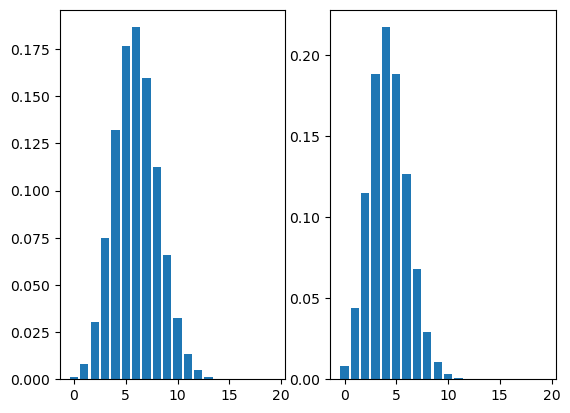

TPS 0.73
Happee 0.27
Avg xg:  TPS 0.26 Happee 0.22


In [99]:
from statistics import mean
k = np.arange(0, 17)

t1xG = team1xGot['xGOT']
t2xG = team2xGot['xGOT']

l_t1 = len(t1xG)
l_t2 = len(t2xG)

avg_t1 = mean(t1xG)
avg_t2 = mean(t2xG)

p_tie = 0
p_team1w = 0
p_team2w = 0           

r_values1 = list(range(l_t1 + 1))
mean, var = binom.stats(l_t1, avg_t1)
dist1 = [binom.pmf(r, len(r_values1), avg_t1) for r in r_values1 ]

r_values2 = list(range(l_t2 + 1))
mean, var = binom.stats(l_t2, avg_t2)
dist2 = [binom.pmf(r, len(r_values2), avg_t2) for r in r_values2 ]

#print(pmf_team1)
#print(pmf_team2)

if len(r_values1) > 20:
    dist1 = dist1[0:20]
else:
    for i in range(len(r_values1), 20):
        dist1.append(0)
if len(r_values2) > 20:
    dist2 = dist2[0:20]
else:
    for i in range(len(r_values2), 20):
        dist2.append(0)

plt.subplot(121)
plt.bar(range(len(dist1)), dist1)
plt.subplot(122)
plt.bar(range(len(dist2)), dist2)
plt.show()

for i in range(len(dist2)):
    p_tie += dist2[i]*dist1[i]
    if i>0:
        for j in range(i):
            p_team2w += dist2[i]*dist1[j]
    
p_team1w = 1 - p_team2w - p_tie/2
p_team2w = p_team2w + p_tie/2

print(team1name, np.round(p_team1w,decimals=2))
print(team2name, np.round(p_team2w,decimals=2))
print("Avg xg: ", team1name, np.round(avg_t1,decimals=2), team2name, np.round(avg_t2,decimals=2))



In [100]:
team1list = players[players['TeamName'] == team1name]
team1list = team1list[team1list.Shots > 0]
team1list = team1list.sort_values(by=['xGOT'], ascending=False)
team1list = team1list.drop(['GameDate','PlayerUniqueID','RoleID','PlayerJerseyNr','Blocked xG','TeamID','Captain'], axis=1)
team1list

,TeamName,PlayerLastName,PlayerFirstName,RoleAbbrv,PlayerLine,xG,xGOT,xGOT/Team,Shots,Goals,Assists
2,TPS,Hautaniemi,Mikko,OL,2,2.8436,3.0852,0.54,12,0,0
17,TPS,Kailiala,Miko,OL,1,0.6167,0.8856,0.15,7,0,1
9,TPS,Trekse,Peteris,VL,1,0.5011,0.6927,0.12,5,1,1
16,TPS,Koskinen,Joonas,OL,3,0.2817,0.3380,0.06,1,0,0
1,TPS,Niemelä,Jere,VP,1,0.3141,0.2228,0.04,4,1,0
18,TPS,Vesterinen,Waltteri,KH,2,0.1377,0.2149,0.04,1,0,1
4,TPS,Hirvisuo,Ville,KH,1,0.0559,0.1649,0.03,1,0,0
15,TPS,Storgårds,Erik,OP,2,0.0384,0.1259,0.02,1,1,0
3,TPS,Laine,Olli-Akseli,VP,2,0.1129,0.0000,0.00,2,0,0
7,TPS,Ojala,Tuomas,VL,2,0.1529,0.0000,0.00,1,0,0


In [101]:
team2list = players[players['TeamName'] == team2name]
team2list = team2list[team2list.Shots > 0]
team2list = team2list.sort_values(by=['xGOT'], ascending=False)
team2list = team2list.drop(['GameDate','PlayerUniqueID','RoleID','PlayerJerseyNr','Blocked xG','TeamID','Captain'], axis=1)
team2list

,TeamName,PlayerLastName,PlayerFirstName,RoleAbbrv,PlayerLine,xG,xGOT,xGOT/Team,Shots,Goals,Assists
20,Happee,Minkkinen,Matti,VL,2,0.4944,0.9118,0.23,4,1,0
30,Happee,Laiti,Niko,OL,1,0.5847,0.5699,0.14,4,1,0
31,Happee,Salmi,Markus,VL,1,0.4337,0.5434,0.13,5,1,0
34,Happee,Manninen,Jami,KH,2,0.5014,0.4609,0.11,5,0,1
27,Happee,Aarela,Ilmari,OL,3,0.2447,0.3388,0.08,1,0,0
22,Happee,Siekkinen,Kaapo,KH,1,0.2611,0.3198,0.08,1,0,0
29,Happee,Koljonen,Perttu,VP,2,0.1217,0.3024,0.08,2,0,1
21,Happee,Laasonen,Roni,OL,2,0.1926,0.2752,0.07,1,1,0
28,Happee,Suhanto,Eppu,VP,1,0.0559,0.1649,0.04,1,0,0
35,Happee,Sipronen,Markus,OP,2,0.0601,0.1447,0.04,1,0,1


TPS Shots: 
35
Happee Shots: 
26


/Users/mikkoalanko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mikkoalanko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


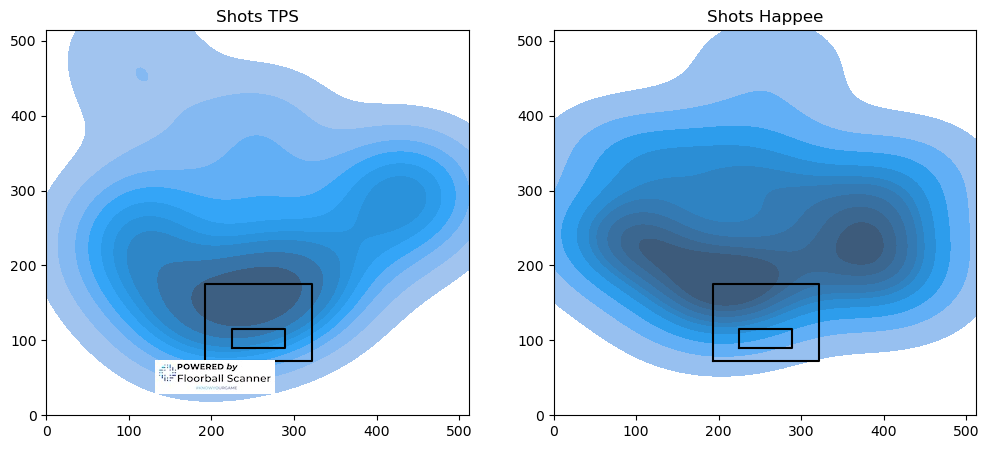

In [102]:
shots['ShotX_side'] = 0
shots['ShotY_side'] = 0

def calcxy(x,y): # Recalculate X and Y to one side

    if x >= 512:
        x2 = maxX - x
        y2 = maxY - y
    else:
        x2 = x
        y2 = y
        
    return (x2, y2)

for nr in range(len(shots)):

    x = float(shots['ShotX'].iloc[nr])
    y = float(shots['ShotY'].iloc[nr])
    (x2, y2) = calcxy(x,y)
    shots['ShotX_side'].iloc[nr] = x2
    shots['ShotY_side'].iloc[nr] = y2

shots1team = shots[(shots['ShootingTeamID'] == team1nr) & (shots['Goaltype'] != "TM") & (shots['Goaltype'] != "RL")]
shots2team = shots[(shots['ShootingTeamID'] == team2nr) & (shots['Goaltype'] != "TM") & (shots['Goaltype'] != "RL")] 
print(team1name + " Shots: ")
print(len(shots1team.index))
print(team2name + " Shots: ")
print(len(shots2team.index))
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

import matplotlib.image as image
logo = image.imread('Powered.jpeg')
fig.figimage(logo, 155, 55, zorder=3, alpha=1)

#Plot One - Shots by Season

plt.subplot(121)

# Draw bigger goalie area
y = [72.96, 72.96, 175.36, 175.36, 72.96]
x = [192.75, 321.25, 321.25, 192.75, 192.75]
plt.plot(x,y,color="black")

# Draw smaller goalie area
y = [89.6, 89.6, 115.2, 115.2, 89.6]
x = [224.875, 289.125, 289.125, 224.875, 224.875]
plt.plot(x,y,color="black")
plt.ylim(0, maxY)
plt.xlim(0, maxX/2)
plt.title('Shots ' + team1name)
sns.kdeplot(shots1team["ShotY_side"], shots1team["ShotX_side"], shade="True")
plt.xlabel('')
plt.ylabel('')

#Plot Two - Goals by Season

plt.subplot(122)

# Draw bigger goalie area
y = [72.96, 72.96, 175.36, 175.36, 72.96]
x = [192.75, 321.25, 321.25, 192.75, 192.75]
plt.plot(x,y,color="black")

# Draw smaller goalie area
y = [89.6, 89.6, 115.2, 115.2, 89.6]
x = [224.875, 289.125, 289.125, 224.875, 224.875]
plt.plot(x,y,color="black")
plt.ylim(0, maxY)
plt.xlim(0, maxX/2)
plt.title('Shots ' + team2name)
sns.kdeplot(shots2team["ShotY_side"], shots2team["ShotX_side"], shade="True")
plt.xlabel('')
plt.ylabel('')
#plt.savefig('Season 22-23 Women SFGF.png')
plt.show()

In [103]:
# Importing the PIL library
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
 
# Open Images
img = Image.open('results_background.jpg')
img_w, img_h = img.size
logo_w = logo_h = 125
data_folder = "./Logos/"
logo_home = Image.open(data_folder + team1name + '.jpg')
logo_home = logo_home.resize((logo_w, logo_h))
logo_away = Image.open(data_folder + team2name + '.jpg')
logo_away = logo_away.resize((logo_w, logo_h))

img.paste(logo_home, (200, 300))
img.paste(logo_away, (img_w-320, 300))

p_t1w = round(100*p_team1w)
p_t2w = round(100*p_team2w)

# Call draw Method to add 2D graphics in an image
I1 = ImageDraw.Draw(img)

# Text strings
goals_text = str(team1go)        + '          Goals          ' + str(team2go)
xG_text = str(team1ot)           + '          xG           ' + str(team2ot)
shots_text = str(team1sh)        + '         Shots         ' + str(team2sh)
shotsot_text = str(team1otshots) + '       Shots OT      ' + str(team2otshots)
winprob_text = str(p_t1w)        + '        Win P%       ' + str(p_t2w)
text_1 = 'VS'

# Custom font style and font size
smallFont = ImageFont.truetype('Montserrat-Regular.ttf', 45)
bigFont = ImageFont.truetype('Montserrat-Regular.ttf', 165)

w1, h1 = I1.textsize(text_1, font=smallFont)
w2, h2 = I1.textsize(goals_text, font=smallFont)
w3, h3 = I1.textsize(xG_text, font=smallFont)
w4, h4 = I1.textsize(shots_text, font=smallFont)
w5, h5 = I1.textsize(shotsot_text, font=smallFont)
w6, h6 = I1.textsize(winprob_text, font=smallFont)


# Add Text to an image
I1.text((467-(w1/2), 340), text_1, font=smallFont, fill = (0, 0, 0))
I1.text(((round(467-w2/2)), 470), goals_text, font=smallFont, fill = (0, 0, 0))
I1.text(((round(467-w3/2)), 540), xG_text, font=smallFont, fill = (0, 0, 0))
I1.text(((round(467-w4/2)), 610), shots_text, font=smallFont, fill = (0, 0, 0))
I1.text(((round(467-w5/2)), 680), shotsot_text, font=smallFont, fill = (0, 0, 0))
I1.text(((round(467-w6/2)), 750), winprob_text, font=smallFont, fill = (0, 0, 0))

# Display edited image
img.show()

img.save('temp.jpg')


/var/folders/w3/hjgng69n26j6r2z674yln_780000gn/T/ipykernel_57069/3643406288.py:37: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w1, h1 = I1.textsize(text_1, font=smallFont)
/var/folders/w3/hjgng69n26j6r2z674yln_780000gn/T/ipykernel_57069/3643406288.py:38: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w2, h2 = I1.textsize(goals_text, font=smallFont)
/var/folders/w3/hjgng69n26j6r2z674yln_780000gn/T/ipykernel_57069/3643406288.py:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w3, h3 = I1.textsize(xG_text, font=smallFont)
/var/folders/w3/hjgng69n26j6r2z674yln_780000gn/T/ipykernel_57069/3643406288.py:40: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w4, h4 = I1.text

# print('.\\Logos\\' + team2name + '.jpg')